# Geostatistics

In [1]:
import verde as vd
import xarray as xr
import xrft
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# geostatistics
import gstatsim as gs 
import skgstat as skg

import cmocean
from pathlib import Path

import itertools
import warnings
from tqdm.auto import tqdm
from utilities import xy_into_grid
import harmonica as hm

from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs
from skgstat import models
from copy import deepcopy

In [2]:
grav=pd.read_csv('gravity_filtered.csv')
bm = xr.open_dataset('bm.nc')

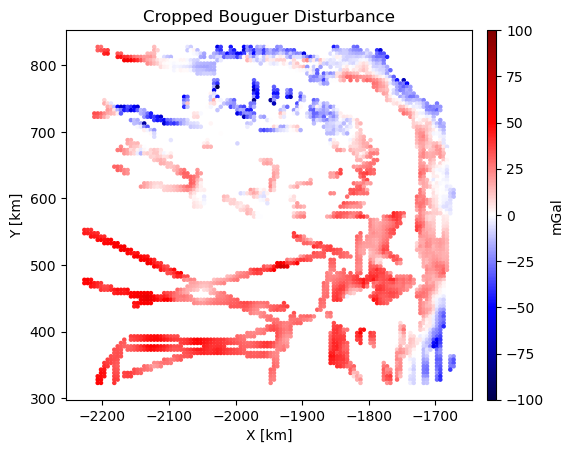

In [3]:
norm=plt.Normalize(vmin=-100, vmax=100)
plt.scatter(grav.x/1000, grav.y/1000, c=grav['boug_dist'],s=5, cmap='seismic', norm=norm)
plt.axis('scaled')
plt.title('Cropped Bouguer Disturbance')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

### Perform a Normal Score Transformation

In [4]:
masked_boug = grav['boug_dist'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(masked_boug)
grav['Normalized boug'] = nst_trans.transform(masked_boug)

In [5]:
grav

,x,y,faa,height,inv_msk,boug_dist,Normalized boug
0,-2207250.0,827750.0,5.127173,1500,0,30.556795,0.727050
1,-2202250.0,827750.0,8.211898,1500,0,27.810425,0.563171
2,-2122250.0,827750.0,-5.709144,1500,0,12.716050,-0.188221
3,-2072250.0,827750.0,-13.528602,1500,0,-5.428226,-0.793483
4,-2067250.0,827750.0,-13.651285,1500,0,-9.615348,-0.948369
...,...,...,...,...,...,...,...
3222,-1767250.0,322750.0,21.661768,1500,0,26.070080,0.442582
3223,-1737250.0,322750.0,-9.436692,1500,0,-3.335808,-0.727140
3224,-1732250.0,322750.0,-10.493384,1500,0,-7.900927,-0.872605
3225,-1717250.0,322750.0,-5.547278,1500,0,-11.788141,-1.018250


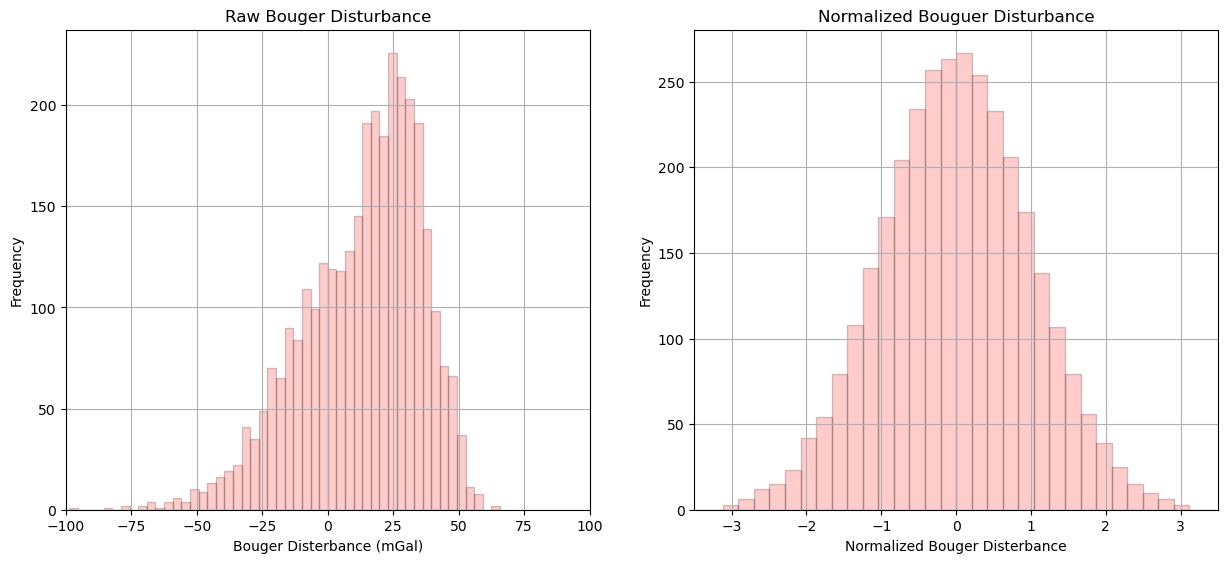

In [6]:
# plot original  histogram
plt.subplot(121)
plt.hist(masked_boug, facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-100,100]); 
plt.xlabel('Bouger Disterbance (mGal)'); plt.ylabel('Frequency'); plt.title('Raw Bouger Disturbance')
plt.grid(True)

# plot normal score histogram (with weights)
plt.subplot(122)
plt.hist(grav['Normalized boug'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized Bouger Disterbance'); plt.ylabel('Frequency'); plt.title('Normalized Bouguer Disturbance')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

The normalized Bouguer disturbance resembles a standard Gaussian distribution, which is what works best for geostatistical manipulation.

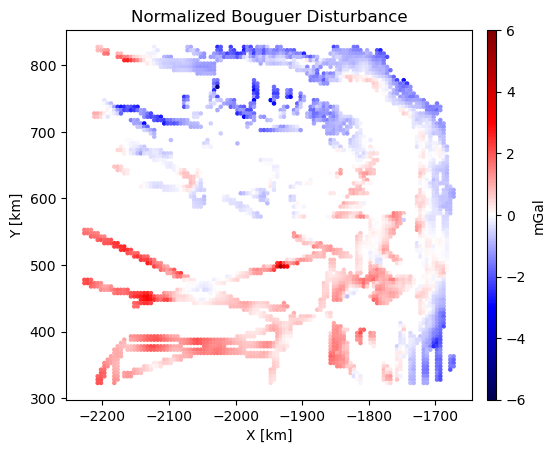

In [7]:
norm=plt.Normalize(vmin=-6, vmax=6)
plt.scatter(grav.x/1000, grav.y/1000, c=grav['Normalized boug'],s=5, cmap='seismic', norm=norm)
plt.axis('scaled')
plt.title('Normalized Bouguer Disturbance')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

### Creating an Experimental Variogram

This variogram will be used to generate stochastic realizations of the Bouguer disturbance.

In [8]:
# compute experimental (isotropic) variogram
coords = grav[['x','y']].values
values = grav['Normalized boug']

maxlag = 200000      # maximum range distance
n_lags = 30         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

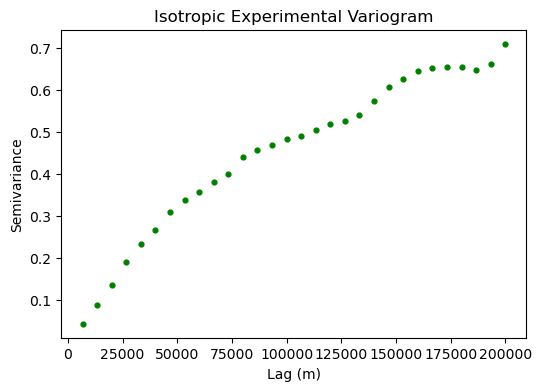

In [9]:
plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

### Testing Different Variogram Models 

In [10]:
# use exponential variogram model
V1.model = 'exponential' 

# use Gaussian model
V2 = deepcopy(V1)
V2.model = 'gaussian' 

# use spherical model
V3 = deepcopy(V1)
V3.model = 'spherical' 

In [11]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_exp = models.exponential(xi, *V1.parameters)
y_gauss = models.gaussian(xi, *V2.parameters)
y_sph = models.spherical(xi, *V3.parameters)

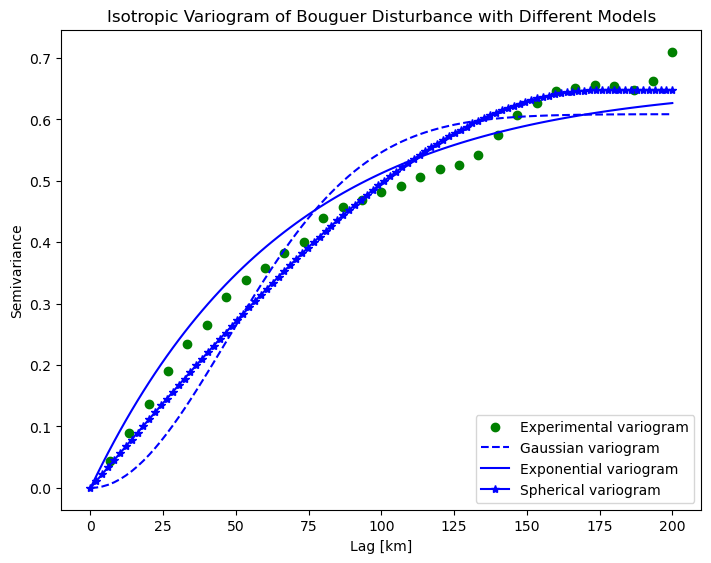

In [12]:
# plot variogram models
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi/1000, y_exp,'b-', label='Exponential variogram')
plt.plot(xi/1000, y_sph,'b*-', label='Spherical variogram')
plt.title('Isotropic Variogram of Bouguer Disturbance with Different Models')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

The exponential variogram model is the best fit at shorter lag distances.

In [13]:
print(grav.columns)

Index(['x', 'y', 'faa', 'height', 'inv_msk', 'boug_dist', 'Normalized boug'], dtype='object')


## Apply Sequential Gaussian Simulation using the Exponential Variogram Model.

In [14]:
#I chose to use ordinary kriging for its better handling of spalital trends
xx,yy=np.meshgrid(bm.x,bm.y)
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vtype = 'Exponential'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 100000    # 100 km search radius

sim1 = gs.Interpolation.okrige_sgs(np.stack((xx.flatten(), yy.flatten()), axis=-1), grav, 'x', 'y', 'Normalized boug', k, vario, rad) 
sim1 = sim1.reshape(-1,1)

100%|████████████████████████████████████████████████████████████████████████████| 13200/13200 [03:09<00:00, 69.60it/s]


In [15]:
# simulation 2
sim2 = gs.Interpolation.okrige_sgs(np.stack((xx.flatten(), yy.flatten()), axis=-1), grav, 'x', 'y', 'Normalized boug', k, vario, rad) 
sim2 = sim2.reshape(-1,1)

# simulation 3
sim3 = gs.Interpolation.okrige_sgs(np.stack((xx.flatten(), yy.flatten()), axis=-1), grav, 'x', 'y', 'Normalized boug', k, vario, rad) 
sim3 = sim3.reshape(-1,1)

100%|████████████████████████████████████████████████████████████████████████████| 13200/13200 [04:10<00:00, 52.70it/s]


In [16]:
sim1=sim1.reshape(xx.shape)
sim2=sim2.reshape(xx.shape)
sim3=sim3.reshape(xx.shape)

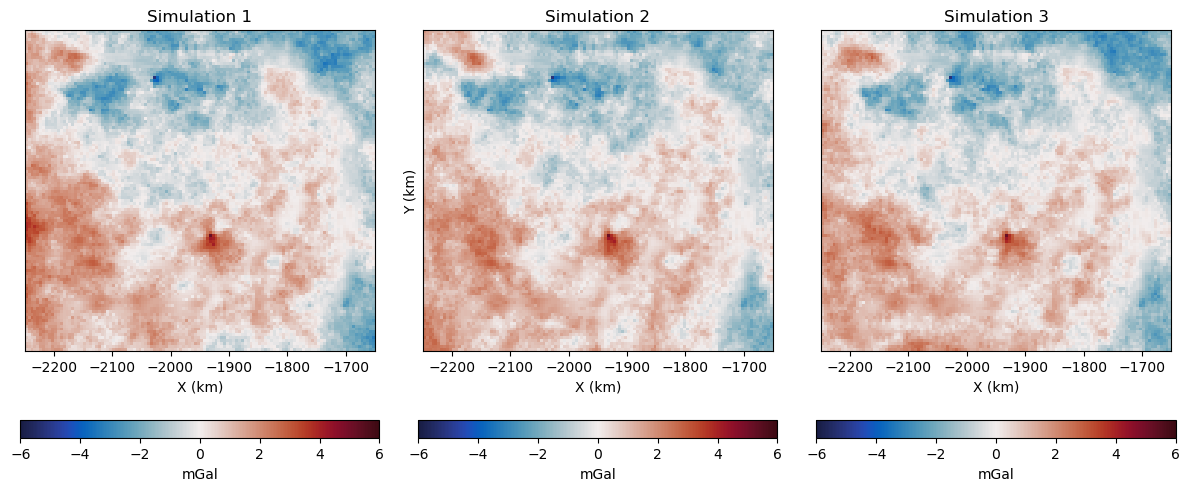

In [17]:
norm=plt.Normalize(vmin=-6, vmax=6)
data=[(sim1,'Simulation 1'), (sim2, 'Simulation 2'), (sim3, 'Simulation 3')]

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
(ax1, ax2, ax3)= axes
axes = axes.flatten()  # flatten the 2D array of axes for easier iteration

for i, (Z,title) in enumerate(data):
    ax = axes[i]
    cmap = ax.pcolormesh(xx / 1000, yy / 1000, Z, cmap='cmo.balance', shading='auto', norm=norm)
    fig.colorbar(cmap, ax=ax, orientation='horizontal', label='mGal')  # adds a colorbar
    ax.set_title(title)
    ax.set_xlabel('X (km)')
    ax.axis('scaled')
    # adds y label to plots in the first colulums
    if i == 1:  
        ax.set_ylabel('Y (km)') # adds y label to plots in the first plot
    else: 
        ax.set_yticks([])  
        ax.set_ylabel('') 

plt.tight_layout()
plt.show()

### Applying a Reverse Normal Score Transformation

In [21]:
sim1 = sim1.reshape(-1,1)
sim2 = sim2.reshape(-1,1)
sim3 = sim3.reshape(-1,1)
sim1_trans = nst_trans.inverse_transform(sim1)
sim2_trans = nst_trans.inverse_transform(sim2)
sim3_trans = nst_trans.inverse_transform(sim3)

In [22]:
sim1_trans=sim1_trans.reshape(xx.shape)
sim2_trans=sim2_trans.reshape(xx.shape)
sim3_trans=sim3_trans.reshape(xx.shape)

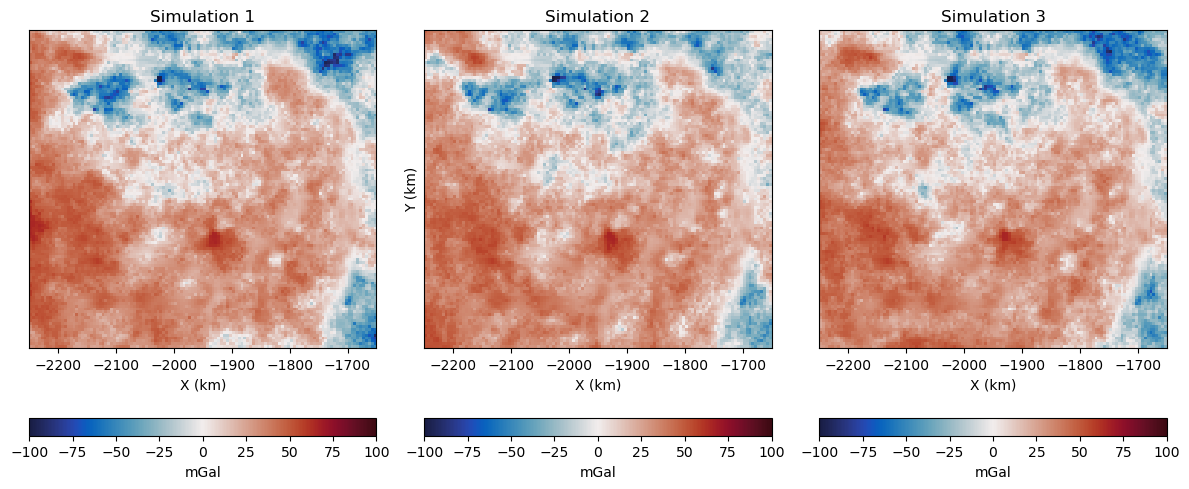

In [27]:
norm=plt.Normalize(vmin=-100, vmax=100)
data=[(sim1_trans,'Simulation 1'), (sim2_trans, 'Simulation 2'), (sim3_trans, 'Simulation 3')]

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
(ax1, ax2, ax3)= axes
axes = axes.flatten()  # flatten the 2D array of axes for easier iteration

for i, (Z,title) in enumerate(data):
    ax = axes[i]
    cmap = ax.pcolormesh(xx / 1000, yy / 1000, Z, cmap='cmo.balance', shading='auto', norm=norm)
    fig.colorbar(cmap, ax=ax, orientation='horizontal', label='mGal')  # adds a colorbar
    ax.set_title(title)
    ax.set_xlabel('X (km)')
    ax.axis('scaled')
    # adds y label to plots in the first colulums
    if i == 1:  
        ax.set_ylabel('Y (km)') # adds y label to plots in the first plot
    else: 
        ax.set_yticks([])  
        ax.set_ylabel('') 

plt.tight_layout()
plt.show()